## Homework 06
### 2.1 Prepare MNIST math dataset

In [185]:
# general imports
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
import datetime
import tqdm

# magic line only needed in jupyter notebooks!
%reload_ext tensorboard

(train_ds, test_ds), ds_info = tfds.load('mnist', split=['train', 'test'], as_supervised=True, with_info=True)

In [188]:
# preprocessing
'''
prepare data to be fed into model
mnist: loaded raw data
batch_size: size of batch, e.g. 32 
sequence_length: length of sequence of numbers that will be used for calculations

'''
def prepare_data(mnist, batch_size, sequence_length):
    
    # change image datatype from unit8 to tf.float32
    mnist = mnist.map(lambda img, target:(tf.cast(img, tf.float32), target))
    # normalize values
    mnist = mnist.map(lambda img, target: (tf.cast(tf.image.per_image_standardization(img), tf.float32), target))
    # batch amount of images depending on the wanted sequence length 
    mnist_sequence =  mnist.shuffle(1000).batch(sequence_length)

    # calculations
    # create alternating positve and negative signes of target values and take cummulative sum
    
    # range to identify which target in the sequence needs with new sign
    range_vals = tf.range(sequence_length)
    # empty lists to store tensors with sequence of images and new tensor with newly calculated target values
    mnist_seq = list()
    mnist_targets = list()
    # for each sequence of images
    for seq in mnist_sequence:
        # take old target values
        target_digits = seq[-1]
        # create alternating signes of target values by checking whether the entry index modulo 2 is zero 
        # (i.e. even entries are positive, uneven ones negative)
        alternating_target_numbers = tf.where(tf.math.floormod(range_vals,2)==0, (target_digits), -(target_digits))
        # take cum. sum and cast it to float32
        new_target = tf.math.cumsum(alternating_target_numbers)
        new_target = tf.cast(new_target, tf.int32)
        # add sequence to a list and add new target values to a list (later we will create the new dataset out of those)
        mnist_seq.append(seq[0])
        mnist_targets.append(new_target)
            
    # create datasets for image sequences and for targets and then zip the two together
    sequences_dataset = tf.data.Dataset.from_tensor_slices(mnist_seq)
    targets_dataset = tf.data.Dataset.from_tensor_slices(mnist_targets)
    mnist_dataset = tf.data.Dataset.zip((sequences_dataset, targets_dataset))
    mnist_dataset = mnist_dataset.map(lambda img, target:(img, tf.one_hot(target, depth = 9*seq_len*2)))

    # cache, batch and prefetch the new dataset
    mnist_dataset = mnist_dataset.cache().batch(batch_size).prefetch(10)
    
    return mnist_dataset

In [189]:
batch_size = 20
seq_len = 5

training_data = prepare_data(train_ds, batch_size, seq_len)
testing_data = prepare_data(test_ds, batch_size, seq_len)

In [215]:
iterator = iter(training_data)
shape = tuple(tf.shape(iterator.get_next()[0]).numpy())

print(shape)

(20, 5, 28, 28, 1)


2022-12-30 23:37:04.485047: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### 2.2 The CNN & LSTM Network

In [191]:
class LSTMCell(tf.keras.layers.AbstractRNNCell):

    def __init__(self, num_hidden_states, num_cell_states, batch_size):
        super().__init__()

        self.hidden_states = num_hidden_states
        self.cell_states = num_cell_states
        self.batch_size = batch_size
        
        self.forget_gate = tf.keras.layers.Dense(self.hidden_states, activation='sigmoid')
        self.input_gate = tf.keras.layers.Dense(self.hidden_states, activation='sigmoid')
        self.cell_gate = tf.keras.layers.Dense(self.cell_states, activation='tanh')
        self.output_gate = tf.keras.layers.Dense(self.cell_states, activation='sigmoid')
    
    @property
    def state_size(self):
        return [tf.TensorShape([self.hidden_states]), 
                tf.TensorShape([self.cell_states])]
    @property
    def output_size(self):
        return [tf.TensorShape([self.cell_states])]
    
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return [tf.zeros([self.batch_size, self.hidden_states], dtype="float32"), 
                tf.zeros([self.batch_size, self.cell_states], dtype="float32")]

    # call method takes (batch of) feature vector(s) as its input, along with the ”states” 
    def call(self, inputs, states):
        
        hidden_state = states[0]
        cell_state = states[1]
        
        forget = self.forget_gate(tf.concat([inputs, hidden_state], 1))
        input_update = self.input_gate(tf.concat([inputs, hidden_state], 1))
        cell_update = self.cell_gate(tf.concat([inputs, hidden_state], 1))
        
        new_cell_state = forget * cell_state + input_update * cell_update
        
        output_update = self.output_gate(tf.concat([inputs, hidden_state], 1))
        
        output = output_update * tf.keras.activations.tanh(new_cell_state)
        
        # return output and the list of new states of the layers
        return output, [output, new_cell_state]

In [222]:
class LSTM_CNN_model(tf.keras.Model):
    def __init__(self, input_shape):
        
        super().__init__()
        
        onehot_number = 9*input_shape[1]*2
        
        # optimzer, metrics, loss
        self.optimizer = tf.keras.optimizers.Adam()

        self.metrics_list = [
                        tf.keras.metrics.Mean(name="loss"),
                        tf.keras.metrics.CategoricalAccuracy(name="acc") 
                       ]

        self.loss_function = tf.keras.losses.CategoricalCrossentropy()
        
        # list of all layers to iterate through during call
        self.layer_list = []
        
        # layers
        self.layer_list.append(tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu', input_shape=input_shape[2:]))
        self.layer_list.append(tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu', input_shape=input_shape[2:]))
        self.layer_list.append(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)))

        self.layer_list.append(tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu', input_shape=input_shape[2:]))
        self.layer_list.append(tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu', input_shape=input_shape[2:]))
        self.layer_list.append(tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalAvgPool2D()))

        self.layer_list.append(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(onehot_number, activation='softmax')))
        
        self.layer_list.append(tf.keras.layers.RNN(LSTMCell(onehot_number, onehot_number, 20), return_sequences=True))
        
    # call funtion
    @tf.function
    def call(self, x):
        for layer in self.layer_list:
            x = layer(x)
        return x
    
    # metrics property
    @property
    def metrics(self):
        return self.metrics_list
        # return a list with all metrics in the model

    # reset all metrics objects
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()
    
    # train step method
    @tf.function
    def train_step(self, data):
        
        x, targets = data
        
        # calculate and backpropagate gradients
        with tf.GradientTape() as tape:
            predictions = self(x, training=True)
            loss = self.loss_function(targets, predictions) + tf.reduce_sum(self.losses)
        
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # update loss metric
        self.metrics[0].update_state(loss)
        
        # update accuracy
        for metric in self.metrics[1:]:
            metric.update_state(targets,predictions)

        # Return a dictionary mapping metric names to current value to keep track of training
        return {m.name: m.result() for m in self.metrics}

    @tf.function
    def test_step(self, data):
        
        # same as in training but without backpropagating
        x, targets = data
        predictions = self(x, training=False)
        loss = self.loss_function(targets, predictions) + tf.reduce_sum(self.losses)
        # update loss metric
        self.metrics[0].update_state(loss)
        # update accuracy metric
        for metric in self.metrics[1:]:
            metric.update_state(targets, predictions)

        return {m.name: m.result() for m in self.metrics}

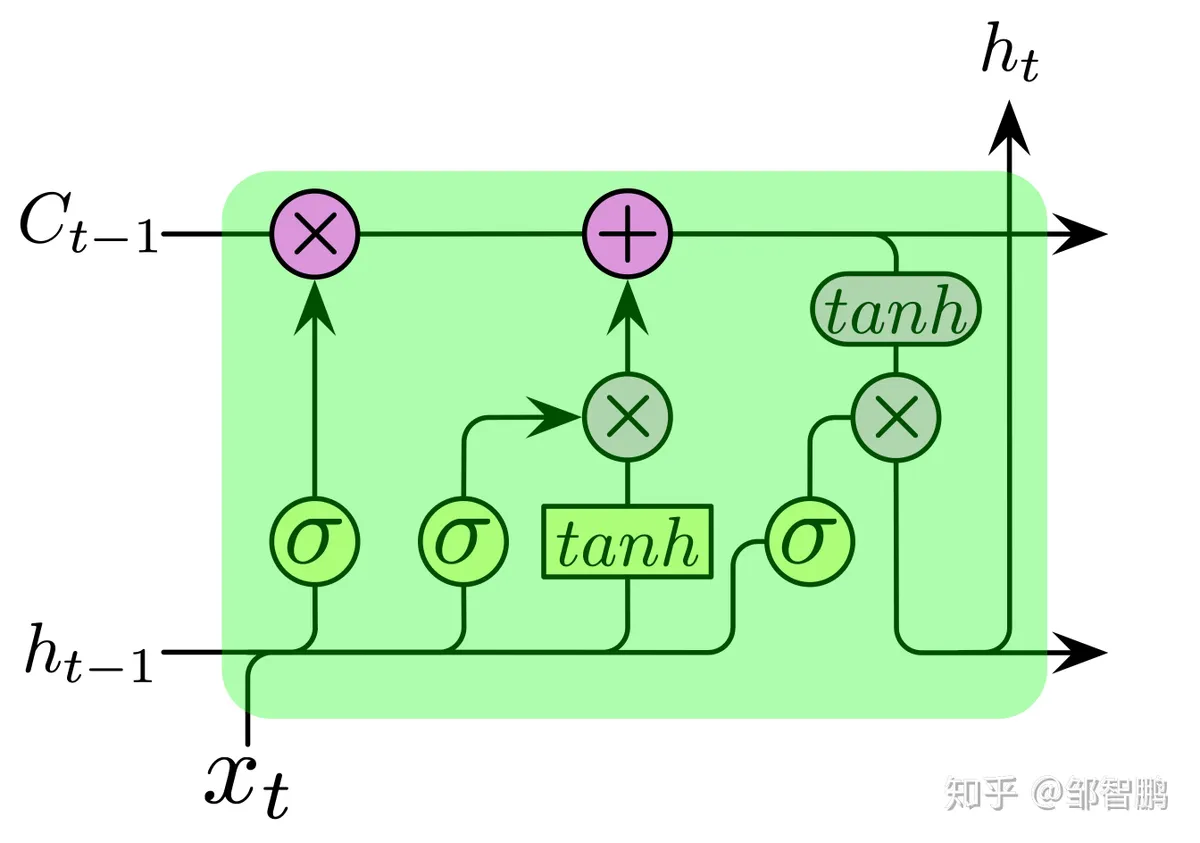

### 4 Training the Network

In [223]:
def training_loop(model, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer):

    # iterate over epochs
    for e in range(epochs):

        # train steps on all batches in the training data
        for data in tqdm.tqdm(train_ds, position=0, leave=True):
            metrics = model.train_step(data)

        # log and print Ltraining metrics
        with train_summary_writer.as_default():
            # for scalar metrics:
            for metric in model.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=e)
            # alternatively, log metrics individually (allows for non-scalar metrics such as tf.keras.metrics.MeanTensor)
            # e.g. tf.summary.image(name="mean_activation_layer3", data = metrics["mean_activation_layer3"],step=e)
        
        #print the metrics
        print([f"{key}: {value.numpy()}" for (key, value) in metrics.items()])
        
        # 4. reset metric objects
        model.reset_metrics()


        # 5. evaluate on validation data
        for data in test_ds:
            metrics = model.test_step(data)
        
        # log validation metrics
        with test_summary_writer.as_default():
            # for scalar metrics:
            for metric in model.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=e)
            # alternatively, log metrics individually (allows for non-scalar metrics such as tf.keras.metrics.MeanTensor)
            # e.g. tf.summary.image(name="mean_activation_layer3", data = metrics["mean_activation_layer3"],step=e)
            
        print([f"test_{key}: {value.numpy()}" for (key, value) in metrics.items()])
        # 7. reset metric objects
        model.reset_metrics()

In [224]:
def create_summary_writers(config_name):
    
    # Define where to save the logs
    # along with this, you may want to save a config file with the same name so you know what the hyperparameters were used
    # alternatively make a copy of the code that is used for later reference
    
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    train_log_path = f"logs/{config_name}/{current_time}/train"
    test_log_path = f"logs/{config_name}/{current_time}/test"

    # log writer for training metrics
    train_summary_writer = tf.summary.create_file_writer(train_log_path)

    # log writer for test metrics
    test_summary_writer = tf.summary.create_file_writer(test_log_path)
    
    return train_summary_writer, test_summary_writer

In [ ]:
train_summary_writer, test_summary_writer = create_summary_writers("model_1")
training_loop(model=LSTM_CNN_model(shape), 
              train_ds=training_data, 
              test_ds=testing_data, 
              epochs= 15, 
              train_summary_writer=train_summary_writer, 
              test_summary_writer=test_summary_writer)

100%|█████████████████████████████████████████| 600/600 [00:20<00:00, 28.74it/s]


['loss: 5.896625995635986', 'acc: 0.07096666842699051']
['test_loss: 5.820245265960693', 'test_acc: 0.06989999860525131']


100%|█████████████████████████████████████████| 600/600 [00:21<00:00, 28.31it/s]


['loss: 5.735086441040039', 'acc: 0.07254999876022339']
['test_loss: 5.820245265960693', 'test_acc: 0.06989999860525131']


100%|█████████████████████████████████████████| 600/600 [00:22<00:00, 27.07it/s]


['loss: 5.735086441040039', 'acc: 0.07254999876022339']
['test_loss: 5.820245265960693', 'test_acc: 0.06989999860525131']


100%|█████████████████████████████████████████| 600/600 [00:22<00:00, 26.48it/s]


['loss: 5.735086441040039', 'acc: 0.07254999876022339']
['test_loss: 5.820245265960693', 'test_acc: 0.06989999860525131']


100%|█████████████████████████████████████████| 600/600 [00:22<00:00, 27.25it/s]


['loss: 5.735086441040039', 'acc: 0.07254999876022339']
['test_loss: 5.820245265960693', 'test_acc: 0.06989999860525131']


100%|█████████████████████████████████████████| 600/600 [00:21<00:00, 27.38it/s]


['loss: 5.735086441040039', 'acc: 0.07254999876022339']
['test_loss: 5.820245265960693', 'test_acc: 0.06989999860525131']


100%|█████████████████████████████████████████| 600/600 [00:21<00:00, 27.49it/s]


['loss: 5.735086441040039', 'acc: 0.07254999876022339']
['test_loss: 5.820245265960693', 'test_acc: 0.06989999860525131']


100%|█████████████████████████████████████████| 600/600 [00:21<00:00, 27.34it/s]


['loss: 5.735086441040039', 'acc: 0.07254999876022339']
['test_loss: 5.820245265960693', 'test_acc: 0.06989999860525131']


100%|█████████████████████████████████████████| 600/600 [00:21<00:00, 27.91it/s]


['loss: 5.735086441040039', 'acc: 0.07254999876022339']
['test_loss: 5.820245265960693', 'test_acc: 0.06989999860525131']


100%|█████████████████████████████████████████| 600/600 [00:21<00:00, 27.28it/s]


['loss: 5.735086441040039', 'acc: 0.07254999876022339']
['test_loss: 5.820245265960693', 'test_acc: 0.06989999860525131']


100%|█████████████████████████████████████████| 600/600 [00:21<00:00, 27.54it/s]


['loss: 5.735086441040039', 'acc: 0.07254999876022339']
['test_loss: 5.820245265960693', 'test_acc: 0.06989999860525131']


100%|█████████████████████████████████████████| 600/600 [00:22<00:00, 26.45it/s]


['loss: 5.735086441040039', 'acc: 0.07254999876022339']
['test_loss: 5.820245265960693', 'test_acc: 0.06989999860525131']


100%|█████████████████████████████████████████| 600/600 [00:22<00:00, 27.04it/s]


['loss: 5.735086441040039', 'acc: 0.07254999876022339']
['test_loss: 5.820245265960693', 'test_acc: 0.06989999860525131']


 93%|██████████████████████████████████████▏  | 559/600 [00:21<00:01, 28.38it/s]

In [ ]:
%tensorboard --logdir \logs  --host localhost